In [1]:
import pandas as pd
import pickle
from functools import reduce

import fpl_methods as methods

with open ('season_data.pickle','rb') as file:
    data = pickle.load(file)


current_gw = max(data["managers"][0].picks)

managers = data["managers"]
players = data["players"]
transfers = data["transfers"]
team = data["teams"]

findings = {}

### GW Standings & Positional Standings 

In [2]:
ranking_targets = ["total", "gk", "def", "mid", "fwd", "bench", "missed", "points_against", "points_difference"]
for target in ranking_targets:
    findings[target + " gw"] = methods.get_ranking_gw(managers,"points",target)
    
    findings[target] = methods.get_ranking(managers,"points",target)

In [3]:
standing_fields = ["h2h_points","wins","draws","losses"]
for field in standing_fields:
    findings[field] = methods.get_ranking(managers,field)

In [4]:
findings["total"]

,manager_short_name,manager,points
0,YE,Youssef E,1347
1,SB,Sandipan B,1318
2,YA,Youssef A,1290
3,SL,Sami L,1241
4,pa,peter a,1205
5,ST,Shrey T,1182
6,YA1,Yahya A,1179
7,ES,Ege S,1143
8,SS,Santi S,1141
9,WN,Will N,1116


### General Standings Table

In [5]:
standings_df = pd.DataFrame(columns=["manager_short","manager","h2h_pts","wins","draws","losses","pts"])

In [7]:
h2h_points = findings["h2h_points"]
wins = findings["wins"]
draws = findings["draws"]
losses = findings["losses"]
points = findings["total"]

data_frames = [h2h_points, wins, draws, losses, points]
standings_table = reduce(lambda left, right: pd.merge(left, right, on=['manager_short_name', 'manager']), data_frames)

In [8]:
standings_table

,manager_short_name,manager,h2h_points,wins,draws,losses,points
0,YE,Youssef E,73,24,1,10,1347
1,YA,Youssef A,68,22,2,11,1290
2,pa,peter a,66,22,0,13,1205
3,SB,Sandipan B,60,20,0,15,1318
4,ST,Shrey T,52,17,1,17,1182
5,WN,Will N,51,17,0,18,1116
6,AB,Anitej B,51,17,0,18,1112
7,SL,Sami L,49,16,1,18,1241
8,SS,Santi S,48,16,0,19,1141
9,ES,Ege S,48,16,0,19,1143


##### Standings week by week

In [34]:
standings_w2w = pd.DataFrame(columns=["manager","h2h points", "points", "gw"])

for man in managers:
    h2h_pts = 0
    for gw in range(1,30):
        pts = man.fixtures[gw]["points"]
        if man.fixtures[gw]["result"] == "W":
            h2h_pts += 3
        elif man.fixtures[gw]["result"] == "D":
            h2h_pts += 1
        standings_w2w.loc[standings_w2w.shape[0]] = {"manager":man.short_name,"h2h points":h2h_pts, "points":pts, "gw":gw}

    

In [48]:
df = standings_w2w.pivot(index="gw",columns="manager",values="h2h points")
row_means = df.mean(axis=1)
avg_dist = df.sub(row_means, axis=0)

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
avg_dist.head()

manager,AA,AB,ES,KS,RK,SB,SL,SS,ST,WN,YA,YA1,YE,pa
gw,,,,,,,,,,,,,,
1,-1.500000,-1.500000,1.500000,-1.500000,1.500000,1.500000,-1.500000,-1.500000,-1.500000,1.500000,1.500000,-1.500000,1.500000,1.500000
2,-3.000000,0.000000,3.000000,-3.000000,0.000000,3.000000,0.000000,-3.000000,-3.000000,0.000000,3.000000,0.000000,0.000000,3.000000
3,-4.428571,1.571429,1.571429,-1.428571,-1.428571,4.571429,1.571429,-4.428571,-4.428571,-1.428571,2.571429,1.571429,-0.428571,4.571429
4,-2.928571,0.071429,3.071429,-2.928571,0.071429,3.071429,0.071429,-5.928571,-5.928571,0.071429,4.071429,3.071429,-1.928571,6.071429
5,-4.357143,1.642857,1.642857,-4.357143,-1.357143,4.642857,-0.357143,-7.357143,-6.357143,1.642857,5.642857,4.642857,-3.357143,7.642857


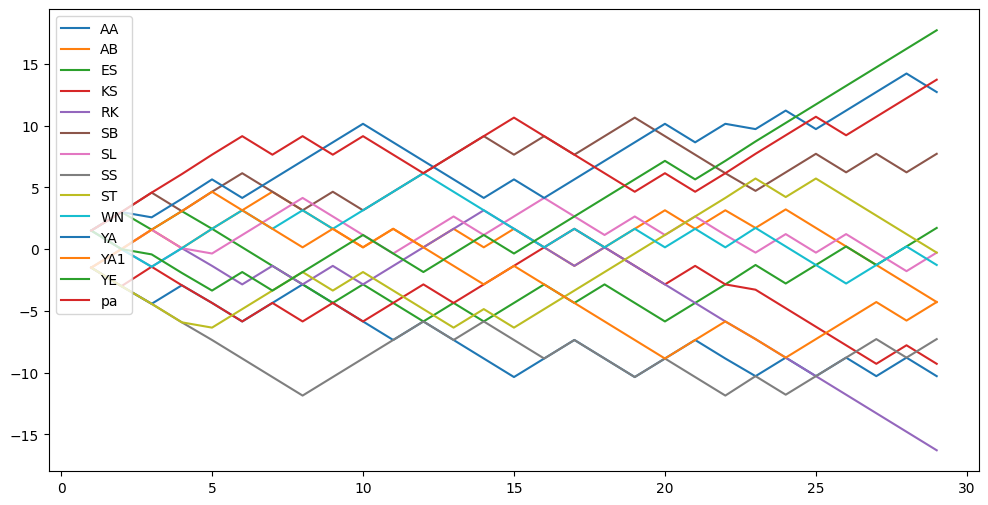

In [72]:
fig, ax = plt.subplots(figsize = (12,6))

ax.plot(avg_dist.index,avg_dist)
ax.legend(avg_dist.columns,loc="upper left")
plt.show()

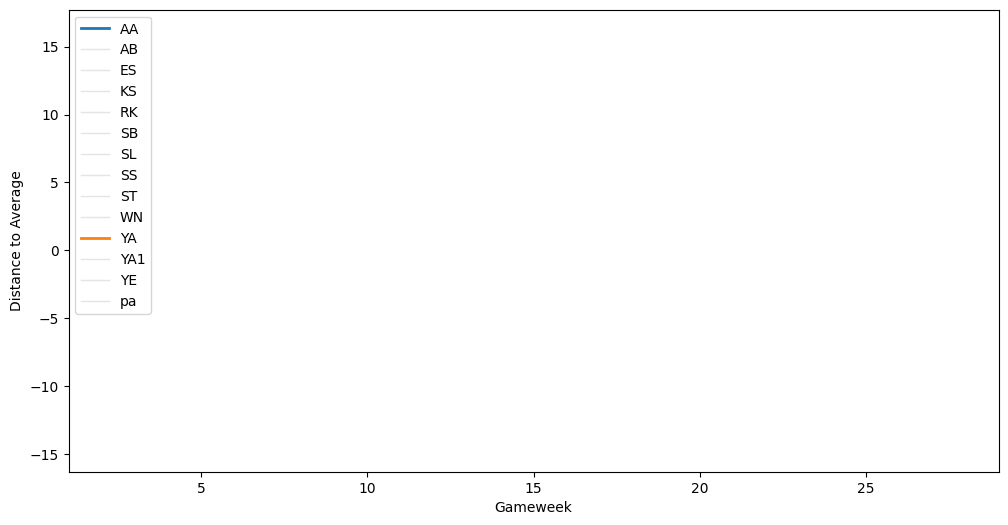

In [88]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

highlighted_managers = ['AA', 'YA']

# Interpolation setup
original_x = avg_dist.index.values
dense_x = np.linspace(original_x.min(), original_x.max(), 300)  # more frames

# Interpolate data
interpolated_data = {}
for col in avg_dist.columns:
    f = interp1d(original_x, avg_dist[col].values, kind='linear')
    interpolated_data[col] = f(dense_x)

# Plot setup
fig, ax = plt.subplots(figsize=(12, 6))
lines = {}
for col in avg_dist.columns:
    is_highlighted = col in highlighted_managers
    color = None if is_highlighted else 'lightgrey'
    lines[col] = ax.plot([], [], label=col, color=color, 
                         linewidth=2 if is_highlighted else 1, 
                         alpha=1.0 if is_highlighted else 0.6)[0]

ax.set_xlim(dense_x.min(), dense_x.max())
ax.set_ylim(avg_dist.min().min(), avg_dist.max().max())
ax.legend(loc='upper left')
ax.set_xlabel("Gameweek")
ax.set_ylabel("Distance to Average")

def init():
    for line in lines.values():
        line.set_data([], [])
    return lines.values()

def update(frame):
    x_vals = dense_x[:frame]
    for col in avg_dist.columns:
        y_vals = interpolated_data[col][:frame]
        lines[col].set_data(x_vals, y_vals)
    return lines.values()

ani = FuncAnimation(fig, update, frames=len(dense_x)+1, init_func=init,
                    blit=True, interval=30, repeat=False)

plt.show()


In [90]:
ani.save("avg_dist_animation.gif", writer="pillow", fps=30)

### Podiums, Tottenham and last places

In [70]:
gw_points = pd.DataFrame(columns=["gw","manager","points"])
for gw in range(1,36):
    for manager in managers:
        points = manager.fixtures[gw]["points"]
        manager = manager
        gw_points.loc[gw_points.shape[0]] = {"gw":gw,"manager":manager,"points":points}
    
    gw_points.loc[gw_points["gw"]==gw,"rank"] = gw_points.loc[gw_points["gw"]==gw,"points"].rank(ascending=False,method="min")

for manager in managers:
    counter = 0
    tottenham = 0
    streak = ""
    for indx, row in gw_points[(gw_points["manager"]==manager)].iterrows():
        if row["rank"]>3:
            counter += 1
            if counter > tottenham:
                tottenham = counter
                start = row["gw"]-tottenham+1
                end = row["gw"]
                streak = f"{start} - {end}"
        else:
            counter = 0

    manager.podiums["1st"] = len(gw_points[(gw_points["manager"]==manager)&(gw_points["rank"]==1)])
    manager.podiums["2nd"] = len(gw_points[(gw_points["manager"]==manager)&(gw_points["rank"]==2)])
    manager.podiums["3rd"] = len(gw_points[(gw_points["manager"]==manager)&(gw_points["rank"]==3)])
    manager.podiums["last"] = len(gw_points[(gw_points["manager"]==manager)&(gw_points["rank"]==14)])
    manager.podiums["tottenham"] = (tottenham,streak)

In [71]:
podiums = pd.DataFrame(columns=["manager","1st","2nd","3rd","last","tottenham","streak"])
for manager in managers:
    podiums.loc[podiums.shape[0]] = {"manager":manager.name + manager.lastname[0],"1st":manager.podiums["1st"],"2nd":manager.podiums["2nd"],"3rd":manager.podiums["3rd"],"last":manager.podiums["last"],"tottenham":manager.podiums["tottenham"][0],"streak":manager.podiums["tottenham"][1]}


In [72]:
podiums

,manager,1st,2nd,3rd,last,tottenham,streak
0,AliA,1,3,2,3,7,5 - 11
1,SamiL,3,2,2,2,10,16 - 25
2,SandipanB,4,3,2,1,8,6 - 13
3,WillN,2,5,4,1,7,20 - 26
4,RuslanK,2,4,1,9,16,15 - 30
5,SantiS,3,0,5,3,12,12 - 23
6,ShreyT,3,1,1,0,14,22 - 35
7,AnitejB,1,1,3,2,21,14 - 34
8,YoussefE,4,7,4,2,5,4 - 8
9,petera,2,1,3,0,14,14 - 27


### H2H

In [8]:
data["managers"][0].fixtures.items()

dict_items([(1, {'result': 'L', 'points': 34, 'opponent': <fpl_classes.FPLmanager object at 0x0000019BA0474340>, 'opponent_points': 40}), (2, {'result': 'L', 'points': 20, 'opponent': <fpl_classes.FPLmanager object at 0x0000019BA0474580>, 'opponent_points': 56}), (3, {'result': 'L', 'points': 20, 'opponent': <fpl_classes.FPLmanager object at 0x0000019BA04743A0>, 'opponent_points': 45}), (4, {'result': 'W', 'points': 43, 'opponent': <fpl_classes.FPLmanager object at 0x0000019BA0474550>, 'opponent_points': 20}), (5, {'result': 'L', 'points': 24, 'opponent': <fpl_classes.FPLmanager object at 0x0000019BA0474400>, 'opponent_points': 47}), (6, {'result': 'L', 'points': 29, 'opponent': <fpl_classes.FPLmanager object at 0x0000019BA04744F0>, 'opponent_points': 36}), (7, {'result': 'W', 'points': 31, 'opponent': <fpl_classes.FPLmanager object at 0x0000019BA0474460>, 'opponent_points': 28}), (8, {'result': 'W', 'points': 33, 'opponent': <fpl_classes.FPLmanager object at 0x0000019BA0474490>, 'oppo

In [9]:
df = pd.DataFrame(columns=["gw","manager","result","points", "opponent","opponent_points"])

for manager in managers:
    for gw, match in manager.fixtures.items():
        match["manager"] = manager.short_name
        match["gw"] = int(gw)
        df.loc[df.shape[0]] = match
        
df["point_diff"] = df["points"] - df["opponent_points"]

In [10]:
df.loc[(df["result"] == "W")].sort_values("points")

,gw,manager,result,points,opponent,opponent_points,point_diff
299,34,AB,W,22,<fpl_classes.FPLmanager object at 0x000001C417...,12,10
66,29,SL,W,24,<fpl_classes.FPLmanager object at 0x000001C417...,16,8
297,32,AB,W,24,<fpl_classes.FPLmanager object at 0x000001C417...,18,6
334,31,YE,W,24,<fpl_classes.FPLmanager object at 0x000001C417...,14,10
206,17,SS,W,24,<fpl_classes.FPLmanager object at 0x000001C417...,19,5
...,...,...,...,...,...,...,...
323,20,YE,W,67,<fpl_classes.FPLmanager object at 0x000001C417...,32,35
411,32,YA,W,68,<fpl_classes.FPLmanager object at 0x000001C417...,47,21
158,7,RK,W,70,<fpl_classes.FPLmanager object at 0x000001C417...,42,28
327,24,YE,W,70,<fpl_classes.FPLmanager object at 0x000001C417...,59,11


In [10]:
h2h_dfs["SL"].head()

,result,points,opponent,opponent_points,manager,point_diff
1,L,37,SB,47,SL,-10
2,W,56,AA,20,SL,36
3,W,30,RK,16,SL,14
4,L,27,WN,33,SL,-6
5,D,36,ST,36,SL,0


In [ ]:
h2h_dfs["SL"].loc[]

##### Average Win, Best Win, Closest Win

In [ ]:
df = df.loc[df["manager"] == "SS"]
win_avg_pts = df.loc[df["result"]=="W"]["points"].mean()
win_avg_opp_pts = df.loc[df["result"]=="W"]["opponent_points"].mean()
print("In the average win, you had", round(win_avg_pts,2), "and they had", round(win_avg_opp_pts,2))

In the average win, you had 40.56 and they had 29.5


In [12]:
df.loc[df["point_diff"]==max(df["point_diff"])]

,result,points,opponent,opponent_points,manager,point_diff
29,W,60,KS,26,SS,34


In [13]:
wins = df.loc[df["result"]=="W"]
wins.loc[wins["point_diff"]==min(wins["point_diff"])]

,result,points,opponent,opponent_points,manager,point_diff
23,W,29,AA,27,SS,2


##### Average loss, Best loss, Closest loss

In [14]:
loss_avg_pts = df.loc[df["result"]=="L"]["points"].mean()
loss_avg_opp_pts = df.loc[df["result"]=="L"]["opponent_points"].mean()
print("In the average loss, you had", round(loss_avg_pts,2), "and they had", round(loss_avg_opp_pts,2))

In the average loss, you had 30.89 and they had 47.0


In [15]:
df.loc[df["point_diff"]==min(df["point_diff"])]

,result,points,opponent,opponent_points,manager,point_diff
5,L,19,SB,55,SS,-36


In [16]:
losses = df.loc[df["result"]=="L"]
losses.loc[losses["point_diff"]==max(losses["point_diff"])]

,result,points,opponent,opponent_points,manager,point_diff
16,L,26,KS,29,SS,-3
21,L,31,WN,34,SS,-3


In [17]:
for man in h2h_dfs.keys():
    
    print(man, "min:", min(h2h_dfs[man]["point_diff"]), "max:", max(h2h_dfs[man]["point_diff"]))

AA min: -36 max: 34
SL min: -35 max: 41
SB min: -23 max: 38
WN min: -31 max: 22
RK min: -37 max: 28
SS min: -36 max: 34
ST min: -22 max: 24
AB min: -30 max: 18
YE min: -41 max: 37
pa min: -31 max: 27
YA min: -20 max: 34
ES min: -38 max: 28
YA1 min: -19 max: 35
KS min: -34 max: 23


In [18]:
h2h_fix.groupby(["opponent","result"]).size().sort_values(ascending=False)

opponent  result
AB        L         3
ST        L         3
SS        W         2
pa        L         2
YE        W         2
RK        L         2
SB        W         2
SL        L         2
YA        D         2
WN        L         2
          W         1
YE        L         1
YA1       W         1
          L         1
          D         1
YA        L         1
AA        D         1
          L         1
SS        L         1
SB        L         1
RK        W         1
ES        W         1
          L         1
          D         1
AA        W         1
pa        W         1
dtype: int64

### Draft Picks

In [11]:
managers[0].draft_picks

{1: <fpl_classes.FPLplayer at 0x1c41467b940>,
 2: <fpl_classes.FPLplayer at 0x1c415925690>,
 3: <fpl_classes.FPLplayer at 0x1c415926290>,
 4: <fpl_classes.FPLplayer at 0x1c4147b7bb0>,
 5: <fpl_classes.FPLplayer at 0x1c41467b6d0>,
 6: <fpl_classes.FPLplayer at 0x1c4147b7eb0>,
 7: <fpl_classes.FPLplayer at 0x1c415925030>,
 8: <fpl_classes.FPLplayer at 0x1c415924190>,
 9: <fpl_classes.FPLplayer at 0x1c4147b7c10>,
 10: <fpl_classes.FPLplayer at 0x1c415926230>,
 11: <fpl_classes.FPLplayer at 0x1c4159255a0>,
 12: <fpl_classes.FPLplayer at 0x1c4147b47f0>,
 13: <fpl_classes.FPLplayer at 0x1c4159252a0>,
 14: <fpl_classes.FPLplayer at 0x1c415925ed0>,
 15: <fpl_classes.FPLplayer at 0x1c4147b4430>}

In [13]:
draft_picks_df = pd.DataFrame(columns=["manager_short","manager","player","pick","pts","gws"])
for pick in range(1,16):
     for manager in managers:
          player = manager.draft_picks[pick]
          gws = 0
          points = 0
          for gw, squad in manager.picks.items():
               for pos in range(1,12):
                    if squad["pos "+str(pos)] == player:
                         gws += 1
                         points += player.points[gw]
          draft_picks_df.loc[draft_picks_df.shape[0]] = {"manager_short":manager.short_name,"manager":manager.name,"player":player.name,"pick":pick,"pts":points,"gws":gws}
draft_picks_df.sort_values("pts",ascending=False)

,manager_short,manager,player,pick,pts,gws
8,YE,Youssef,M.Salah,1,317,31
40,YA1,Yahya,Mbeumo,3,192,32
7,AB,Anitej,Palmer,1,192,32
13,KS,Kian,Isak,1,190,29
122,YA,Youssef,Wood,9,176,30
...,...,...,...,...,...,...
133,AB,Anitej,Almirón,10,0,0
131,SS,Santi,Mudryk,10,0,0
130,RK,Ruslan,Kiwior,10,0,1
149,pa,peter,Senesi,11,0,0


### Stats

In [ ]:
targets = ["goals_scored","assists","clean_sheets","goals_conceded","own_goals","penalties_saved","penalties_missed",
          "yellow_cards","red_cards","saves","bonus","in_dreamteam"]

for target in targets:
    findings[target] = methods.get_stat_ranking(managers, target)
    

In [26]:
findings["in_dreamteam"]

,manager_short_name,manager,in_dreamteam
0,AA,Ali,22
1,SL,Sami,25
2,SB,Sandipan,24
3,WN,Will,16
4,RK,Ruslan,21
5,SS,Santi,17
6,ST,Shrey,14
7,AB,Anitej,19
8,YE,Youssef,31
9,pa,peter,22


### Players

##### Loyalty and Unloyalty - the players each manager has had the most and least

In [27]:
loyalty_df = pd.DataFrame(columns=["manager_short","manager","player","pos","team","pts","gw"])
for manager in managers:
    for gw, squad in manager.picks.items():
        for pos in range(1,16):
            player = squad["pos "+str(pos)]
            loyalty_df.loc[loyalty_df.shape[0]] = {"manager_short":manager.short_name,"manager":manager.name,"pos":pos,"player":player.ID,"team":player.team.name,"pts":player.points[gw],"gw":gw}
fielded = loyalty_df[loyalty_df["pos"]<=11]

In [ ]:
loyalty_df.groupby(["manager_short","manager","player"])["gw"].count().sort_values()

manager_short  manager  player
AB             Anitej   527        1
                        449        1
                        417        1
                        415        1
                        391        1
                                  ..
YA             Youssef  348       32
                        327       32
                        252       32
SS             Santi    366       32
ES             Ege      91        32
Name: gw, Length: 553, dtype: int64

##### Most Teams Played In - the players that have played for most managers

In [4]:
loyalty_df[["player", "manager_short"]].drop_duplicates().groupby("player").count().sort_values("manager_short",ascending=False).head(10)

,manager_short
player,
409,4
171,4
83,4
362,4
181,4
560,4
349,4
44,4
524,4


##### Club mascot - the team each manager has fielded most

In [6]:
grouped = loyalty_df[loyalty_df["pos"]<=11].groupby(["manager_short","manager","team"])["player"].count().sort_values()

###### The biggest representer of each team

In [7]:
grouped.loc[grouped.groupby("team").idxmax()].sort_values()

manager_short  manager   team
ST             Shrey     SOU     27
YA1            Yahya     LEI     30
SS             Santi     WOL     31
YA1            Yahya     CRY     41
YE             Youssef   EVE     41
ST             Shrey     BOU     45
SB             Sandipan  NFO     45
SL             Sami      BHA     46
SS             Santi     IPS     51
YA1            Yahya     FUL     55
ES             Ege       MUN     56
AA             Ali       AVL     59
AB             Anitej    CHE     60
YE             Youssef   BRE     60
YA             Youssef   NEW     72
pa             peter     MCI     73
AA             Ali       WHU     77
AB             Anitej    LIV     78
SL             Sami      TOT     92
RK             Ruslan    ARS     97
Name: player, dtype: int64

##### Star Players - the players with most points for each manager

In [31]:
star = fielded.groupby(["manager_short","manager","player"]).agg(
    gws=('gw', 'count'),
    pts=('pts', 'sum')
).sort_values("pts",ascending=False).reset_index()
star["pts_gw"] = round(star["pts"]/star["gws"],2)

In [37]:
star.sort_values("pts_gw")[-20:]

,manager_short,manager,player,gws,pts,pts_gw
160,ES,Ege,742,6,34,5.67
44,ES,Ege,432,18,102,5.67
4,YA,Youssef,447,30,176,5.87
2,YA1,Yahya,99,32,192,6.00
1,AB,Anitej,182,32,192,6.00
311,ES,Ege,25,1,6,6.00
307,SB,Sandipan,678,1,6,6.00
306,AB,Anitej,581,1,6,6.00
302,KS,Kian,171,1,6,6.00
300,SS,Santi,376,1,6,6.00


In [36]:
methods.get_player(418,players).name

'Trippier'

### Transfers

##### Most Transfers

In [21]:
df = pd.DataFrame(columns=["manager_short_name","manager","num_transfers"])
for man in managers:
    transfer_count = 0
    for transfer in man.transfers:
        if transfer.result == "a":
            transfer_count+=1
        
    df.loc[df.shape[0]] = {"manager_short_name":man.short_name,"manager":man.name,"num_transfers": transfer_count}

df.sort_values("num_transfers", ascending=False).reset_index(drop=True)

,manager_short_name,manager,num_transfers
0,AA,Ali,70
1,AB,Anitej,60
2,SB,Sandipan,57
3,SS,Santi,43
4,ES,Ege,37
5,SL,Sami,36
6,KS,Kian,29
7,YE,Youssef,19
8,ST,Shrey,16
9,WN,Will,14


##### Most Transferred In

In [22]:
df = pd.DataFrame(columns=["manager_short_name","manager","player","num_transfers"])
for man in managers:
    for tran in man.transfers:
        if tran.result == "a":
            if tran.player_in.name in df["player"].values:
                df.loc[df["player"] == tran.player_in.name,"num_transfers"] += 1
            else:
                df.loc[df.shape[0]] = {"manager_short_name":man.short_name,"manager":man.name,"player":tran.player_in.name, "num_transfers": 1}

df = df.loc[df["num_transfers"]>1].sort_values("num_transfers",ascending=False).reset_index(drop=True)
df[:20]

,manager_short_name,manager,player,num_transfers
0,SL,Sami,Tavernier,5
1,AA,Ali,Neto,4
2,AA,Ali,Lamptey,4
3,AA,Ali,Bradley,4
4,SL,Sami,Gusto,4
5,AA,Ali,Livramento,4
6,SB,Sandipan,Tarkowski,4
7,AA,Ali,Trippier,4
8,AA,Ali,McNeil,4
9,SB,Sandipan,Beto,4


In [23]:
managers[0].transfers[0].player_in.name

'Mazraoui'

##### Best & Worst Transfers

In [24]:
managers[0].transfers[0].gameweek
player_name = managers[0].transfers[0].player_in.name

In [25]:
player_name

'Mazraoui'

In [ ]:
man.picks

{1: {'pos 1': <fpl_classes.FPLplayer at 0x1f154c2c130>,
  'pos 2': <fpl_classes.FPLplayer at 0x1f1534bfe50>,
  'pos 3': <fpl_classes.FPLplayer at 0x1f15337b670>,
  'pos 4': <fpl_classes.FPLplayer at 0x1f154c2e320>,
  'pos 5': <fpl_classes.FPLplayer at 0x1f154c2de70>,
  'pos 6': <fpl_classes.FPLplayer at 0x1f154c2d630>,
  'pos 7': <fpl_classes.FPLplayer at 0x1f1534bfb50>,
  'pos 8': <fpl_classes.FPLplayer at 0x1f154c2cfd0>,
  'pos 9': <fpl_classes.FPLplayer at 0x1f154c2e1d0>,
  'pos 10': <fpl_classes.FPLplayer at 0x1f15337b8e0>,
  'pos 11': <fpl_classes.FPLplayer at 0x1f154c2e230>,
  'pos 12': <fpl_classes.FPLplayer at 0x1f1534bfdc0>,
  'pos 13': <fpl_classes.FPLplayer at 0x1f154c2d240>,
  'pos 14': <fpl_classes.FPLplayer at 0x1f154c2d540>,
  'pos 15': <fpl_classes.FPLplayer at 0x1f1534bc790>,
  'formation': [3, 5, 1]},
 2: {'pos 1': <fpl_classes.FPLplayer at 0x1f154c2c130>,
  'pos 2': <fpl_classes.FPLplayer at 0x1f15337b670>,
  'pos 3': <fpl_classes.FPLplayer at 0x1f1534bfe50>,
  'pos 

In [ ]:
df = pd.DataFrame(columns=["manager_short_name","manager","gameweek","player_in","player_out","gws","in_pts","out_pts","pts_gain"])
current_gw = 32
for man in managers:                                            # for every manager
    for tran in man.transfers:                                  # for every one of their transfers
        in_pts = 0
        out_pts = 0
        gws = 0

        if tran.result == "a":                                  # for every accepted transfer
            tran_gw = tran.gameweek
            player_in = tran.player_in
            player_out = tran.player_out

            for gw in range(tran_gw,min(tran_gw+3,current_gw)): # for the next three gws after the transfer
                position = 0
                for pos, player in man.picks[gw].items():       # check all the players in the manager's 11
                    position += 1
                    if position <= 15:
                        if player == player_in:
                            gws += 1
                            in_pts += player.points[gw]
                            out_pts += player_out.points[gw]
            row = {"manager_short_name":man.short_name,"manager":man.name, "gameweek":tran_gw,"player_in":player_in.name, "player_out":player_out.name,"gws":gws,"in_pts":in_pts,"out_pts":out_pts,"pts_gain":in_pts-out_pts}
            df.loc[df.shape[0]] = row

df.sort_values("pts_gain")

,manager_short_name,manager,gameweek,player_in,player_out,gws,in_pts,out_pts,pts_gain
235,ST,Shrey,14,Werner,J.Murphy,3,3,22,-19
314,YE,Youssef,6,Tosin,Aït-Nouri,3,0,19,-19
328,pa,peter,4,Kerkez,De Ligt,3,4,22,-18
170,WN,Will,10,Beto,Armstrong,3,3,16,-13
416,KS,Kian,29,Todibo,Gusto,3,2,14,-12
...,...,...,...,...,...,...,...,...,...
114,SB,Sandipan,5,McNeil,Odobert,3,19,0,19
215,SS,Santi,24,Marmoush,Ings,3,21,1,20
323,YE,Youssef,16,Huijsen,White,3,24,0,24
27,AA,Ali,11,Amad,Carvalho,3,25,1,24
